The MNIST (Modified National Institute of Standards and Technology) dataset is set of images of hand-written digits. The images are greyscale and have the size of 28x28 pixels. It is a very common dataset for testing and benchmarking machine learning algorithms. You can read more about it here: https://en.wikipedia.org/wiki/MNIST_database, or you can check the digit recognizer kaggle competition: https://www.kaggle.com/competitions/digit-recognizer.

Working with the MNIST dataset, our task is to recognize hand-written digits.

I am going to try out different approaches to build and train a neural network, starting with the most simple one, then optimizing its parameters, then using different techniques.

First let's load the training data. The input files and the train/test split is provided by tensorflow.

In [1]:
import tensorflow as tf
from tensorflow import keras


(x, y), (validation_x, validation_y) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
print(x.shape)
print(validation_x.shape)
x = x.reshape(60000, 784)
validation_x = validation_x.reshape(10000, 784)
print(x.shape)
print(validation_x.shape)


(60000, 28, 28)
(10000, 28, 28)
(60000, 784)
(10000, 784)


Now let's build and train the first model, a sequential model with 3 dense layers between the input and output layers. The number of units are chosen by simply following the "usual shape" of models of similar tasks. Probably more about it later.

For the output layer I chose linear activation instead of softmax, while setting from_logits=True for the loss function -- a trick I have learned from Andrew Ng's course to prevent some rounding errors.

In [2]:
def create_model(alpha=0.001):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.Input(shape=(784,)))
    model.add(tf.keras.layers.Dense(1000, activation='relu'))
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dense(200, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='linear'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(alpha))
    return model


Check accuracy of digit recognition both on the train and the validation set:

In [5]:
import numpy as np


def accuracy(model, x, y, verbose=False):

    n = len(y)
    output = model.predict(x)
    yhat = np.empty(n, dtype=int)
    for i in range(n):
        digit = output[i].argmax()
        yhat[i] = digit
    wrong_count = 0
    for i in range(n):
        if y[i] != yhat[i]:
            if verbose:
                print(f"Wrongly predicted {yhat[i]}, but it was {y[i]}")
            wrong_count += 1
    accuracy = 1 - wrong_count/n
    return accuracy


model = create_model(alpha=0.0001)
model.fit(x, y, epochs=1)
print(f"Accuracy on the training set: {accuracy(model, x, y)}")
print(f"Accuracy on the validation set: {accuracy(model, validation_x, validation_y)}")

1000/1000 [==============================] - 5s 5ms/step
Accuracy on the training set: 0.93109375
313/313 [==============================] - 2s 5ms/step
Accuracy on the validation set: 0.913


It is already above 90% -- a good baseline to start with.

Now let's explore how much difference the number of epochs and the parameter alpha of the optimizer make. If you want to speed it up just change the number of calculated steps (N) of the next code snippets.

(side note: the optimal choice of epochs remains the same regardless of the learning rate, that's why we can optimize them in distinct steps. You can try changing the constants and check the results)

313/313 [==============================] - 2s 5ms/step


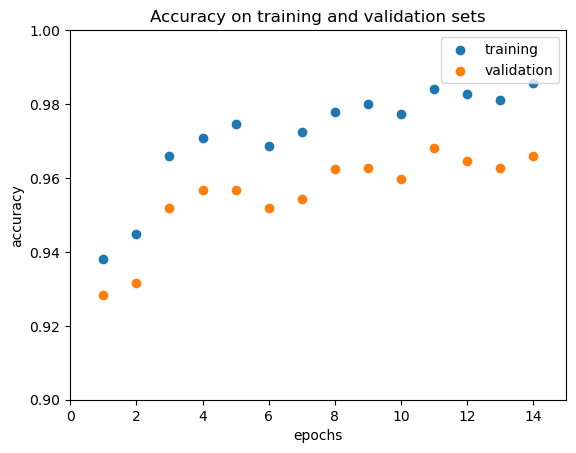

In [21]:
import matplotlib.pyplot as plt


def plot_accuracy(train_accuracy, validation_accuracy, xlabel, xlim_min, xlim_max, ylim_min, ylim_max):
    plt.scatter(train_accuracy[:, 0], train_accuracy[:, 1], label='training')
    plt.scatter(validation_accuracy[:, 0], validation_accuracy[:, 1], label='validation')
    plt.title('Accuracy on training and validation sets')
    plt.xlabel(xlabel)
    plt.ylabel('accuracy')
    plt.xlim(xlim_min, xlim_max)
    plt.ylim(ylim_min, ylim_max)
    plt.legend()
    plt.show()
    

N = 14
model = create_model()
epoch_train_accuracy = np.empty([N,2])
epoch_validation_accuracy = np.empty([N,2])
for i in range(N):
    epochs = i+1
    model.fit(x, y, epochs=1)
    epoch_train_accuracy[i][0]=epochs
    epoch_train_accuracy[i][1]=accuracy(model, x, y)
    epoch_validation_accuracy[i][0]=epochs
    epoch_validation_accuracy[i][1]=accuracy(model, validation_x, validation_y)
plot_accuracy(epoch_train_accuracy, epoch_validation_accuracy, 'epochs', 0, 15, 0.9, 1)

What we can see on the plot is that training with more epochs leads to better results, but above 9 it is not significant. This is true independently of changing the learning rate, Considering your limits in runtime we can choose the number of epochs 5 or 11.

Now let's take a look at the Adam optimizer's learning rate.

313/313 [==============================] - 2s 5ms/step


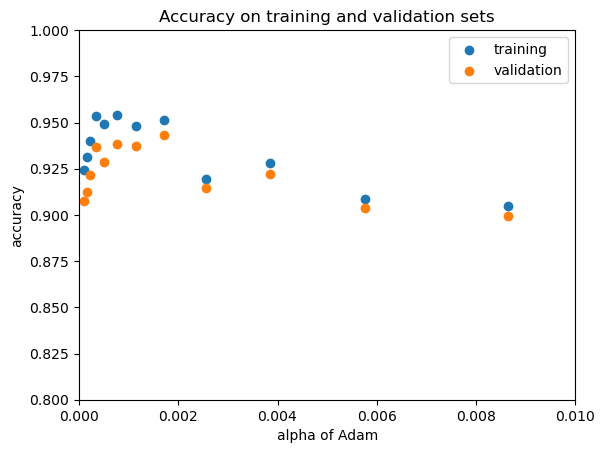

In [48]:
N = 12
alpha_train_accuracy = np.empty([N,2])
alpha_validation_accuracy = np.empty([N,2])

for i in range(N):
    test_alpha=0.0001 * (1.5)**i
    model = create_model(alpha=test_alpha)
    model.fit(x, y)
    alpha_train_accuracy[i][0]=test_alpha
    alpha_train_accuracy[i][1]=accuracy(model, x, y)
    alpha_validation_accuracy[i][0]=test_alpha
    alpha_validation_accuracy[i][1]=accuracy(model, validation_x, validation_y)
plot_accuracy(alpha_train_accuracy, alpha_validation_accuracy, 'alpha of Adam', 0, 0.01, 0.8, 1)


We can already see that the maximum is around 0.001. Let's zoom in, enhance it!

313/313 [==============================] - 2s 5ms/step


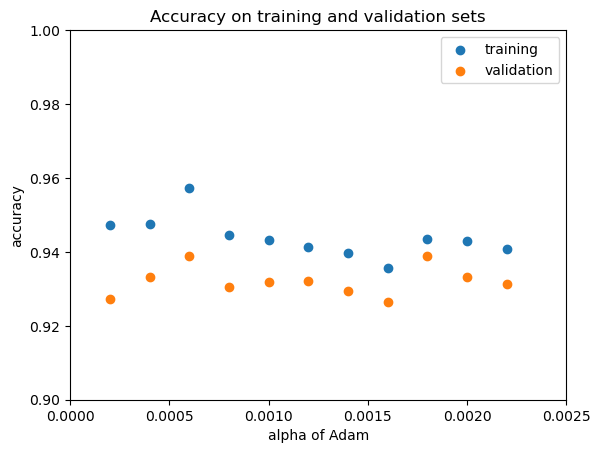

In [20]:
N = 11
alpha_train_accuracy = np.empty([N,2])
alpha_validation_accuracy = np.empty([N,2])
for i in range(N):
    test_alpha=0.0002 + i * 0.0002
    model = create_model(alpha=test_alpha)
    model.fit(x, y)
    alpha_train_accuracy[i][0]=test_alpha
    alpha_train_accuracy[i][1]=accuracy(model, x, y)
    alpha_validation_accuracy[i][0]=test_alpha
    alpha_validation_accuracy[i][1]=accuracy(model, validation_x, validation_y)
plot_accuracy(alpha_train_accuracy, alpha_validation_accuracy, 'alpha of Adam', 0, 0.0025, 0.9, 1)


side note: We don't have to do the parameter optimization manually, there are several implementations of grid search that we can use. You can run the next 2 cells to see how the sklearn implementation works.

In [3]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(model=create_model, alpha=0.001)
epochs=[1]
alpha=[0.0001, 0.001, 0.01]
param_grid = dict(epochs=epochs, alpha=alpha)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2)
grid_result = grid.fit(x, y)

1875/1875 [==============================] - 31s 16ms/step - loss: 0.9210


In [4]:
grid_result.cv_results_

{'mean_fit_time': array([53.45219982, 54.80795634, 52.82696867]),
 'std_fit_time': array([0.13304079, 2.01594508, 0.00298333]),
 'mean_score_time': array([14.93493235, 13.85173023, 15.25166583]),
 'std_score_time': array([0.03420579, 1.38695586, 0.02096558]),
 'param_alpha': masked_array(data=[0.0001, 0.001, 0.01],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_epochs': masked_array(data=[1, 1, 1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.0001, 'epochs': 1},
  {'alpha': 0.001, 'epochs': 1},
  {'alpha': 0.01, 'epochs': 1}],
 'split0_test_score': array([0.92263333, 0.93713333, 0.2031    ]),
 'split1_test_score': array([0.91926667, 0.9274    , 0.88383333]),
 'mean_test_score': array([0.92095   , 0.93226667, 0.54346667]),
 'std_test_score': array([0.00168333, 0.00486667, 0.34036667]),
 'rank_test_score': array([2, 1, 3])}

There are no significant differences. Let's choose 0.0018 as alpha and see how it goes.

In [29]:
model = create_model(alpha=0.0018)
model.fit(x, y, epochs=5)
print(f"Accuracy on the training set: {accuracy(model, x, y)}")
print(f"Accuracy on the validation set: {accuracy(model, validation_x, validation_y)}")

Epoch 1/11
1000/1000 [==============================] - 19s 18ms/step - loss: 1.8775
Epoch 2/11
1000/1000 [==============================] - 17s 17ms/step - loss: 0.2452
Epoch 3/11
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1819
Epoch 4/11
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1681
Epoch 5/11
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1679
Epoch 6/11
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1538
Epoch 7/11
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1358
Epoch 8/11
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1319
Epoch 9/11
1000/1000 [==============================] - 17s 17ms/step - loss: 0.1285
Epoch 10/11
1000/1000 [==============================] - 18s 18ms/step - loss: 0.1410
Epoch 11/11
1000/1000 [==============================] - 5s 5ms/step
Accuracy on the training set: 0.97478125
313/313 [==============================

Above 95%! I am very happy with this number, but I wonder what the typical errors are, is there a pattern there? If we find many cases of the same type of errors, we can choose training data that focuses on those changes and improve the results.

In [46]:
def predictions(model, x, y):

    n = len(y)
    output = model.predict(x)
    yhat = np.empty(n, dtype=int)
    for i in range(n):
        digit = output[i].argmax()
        yhat[i] = digit
    predictions = np.full((10,10), 0, dtype=int)
    for i in range(n):
        predictions[y[i]][yhat[i]] += 1
    return predictions


predictions(model, validation_x, validation_y)


313/313 [==============================] - 2s 5ms/step


array([[ 980,    0,    2,    0,    5,    0,    6,    2,   14,    2],
       [   0, 1107,    1,    1,   23,    2,    1,    2,    2,    0],
       [   4,   10,  855,   24,   12,    0,    4,   16,   33,    5],
       [   1,    3,    2, 1004,    2,    7,    0,    2,   13,   15],
       [   0,    4,    0,    0,  905,    0,    6,    1,    3,   13],
       [   2,    1,    1,   21,    2,  840,    4,    0,   17,    4],
       [   4,    2,    0,    0,    2,    8,  972,    0,    3,    0],
       [   0,    0,    1,    8,    3,    0,    0, 1035,    3,    8],
       [   0,    6,    1,    4,   15,    5,    0,    1,  932,    5],
       [   3,    1,    1,    5,   18,   12,    0,    9,    8,  939]])

There is clearly a problem with recognising '2', it is only 89% accurate. We could add more examples for a hand-written '2', either by collecting or generating more images. Also, taking a look at the training data can reveal that there is a different way of writing the digit.

But let's go for some bigger impact and take a different approach with using convolutional layers.

In [6]:
def create_convolutional_model(alpha=0.001):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='linear'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(alpha))
    return model


x_formatted = x.reshape(32000,28,28)
validation_x_formatted = validation_x.reshape(10000,28,28)
conv_model = create_convolutional_model()
conv_model.fit(x_formatted, y, epochs=1)

1000/1000 [==============================] - 21s 20ms/step - loss: 0.3731


In [7]:
print(f"Accuracy on the training set: {accuracy(conv_model,x_formatted,y)}")
print(f"Accuracy on the validation set: {accuracy(conv_model, validation_x_formatted, validation_y)}")

1000/1000 [==============================] - 7s 7ms/step
Accuracy on the training set: 0.9790625
313/313 [==============================] - 2s 7ms/step
Accuracy on the validation set: 0.9748


The results show immediately that convolutional neural networks (CNNs) are for image processing. This very first try performs better than the simple NN.

For more improvements I asked a good friend Istvan Estelyi to share some of his experience with CNNs. I used his advice, and created this version:

In [8]:
def create_and_train_model_functional(x_, y_, alpha=0.001, epoch=1):
    x = tf.keras.Input(shape=(28, 28, 1))
    conv_layer_1 = tf.keras.layers.Conv2D(filters = 64, kernel_size=[5,5], padding="same",
                                          activation='relu')(x)
    pool_layer_1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)(conv_layer_1)
    conv_layer_2 = tf.keras.layers.Conv2D(filters = 64, kernel_size=[5,5], padding="same",
                                          activation='relu')(pool_layer_1)
    pool_layer_2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)(conv_layer_2)
    pool_layer_2_flat = tf.keras.layers.Flatten()(pool_layer_2)
    layer1 = tf.keras.layers.Dense(512, activation='relu')(pool_layer_2_flat)
    dropout1 = tf.keras.layers.Dropout(rate=0.2)(layer1)
    layer2 = tf.keras.layers.Dense(256, activation='relu')(dropout1)
    dropout2 = tf.keras.layers.Dropout(rate=0.2)(layer2)
    layer3 = tf.keras.layers.Dense(128, activation='relu')(dropout2)
    output = tf.keras.layers.Dense(10, activation='linear')(layer3)
    model = tf.keras.models.Model(inputs=x, outputs=output)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(alpha))
    model.fit(x=x_, y=y_, epochs=epoch, batch_size=100)
    return model


conv_model_2 = create_and_train_model_functional(x_formatted, y, epoch=5)

Epoch 1/5
320/320 [==============================] - 93s 287ms/step - loss: 0.4717
Epoch 2/5
320/320 [==============================] - 91s 286ms/step - loss: 0.0849
Epoch 3/5
320/320 [==============================] - 92s 286ms/step - loss: 0.0624
Epoch 4/5
320/320 [==============================] - 90s 282ms/step - loss: 0.0526
Epoch 5/5
320/320 [==============================] - 91s 283ms/step - loss: 0.0453


In [9]:
print(f"Accuracy on the training set: {accuracy(conv_model_2,x_formatted,y)}")
print(f"Accuracy on the validation set: {accuracy(conv_model_2, validation_x_formatted, validation_y)}")

1000/1000 [==============================] - 23s 23ms/step
Accuracy on the training set: 0.99475
313/313 [==============================] - 7s 22ms/step
Accuracy on the validation set: 0.9869
